In [1]:
from data_loader import LakesDataset
from architecture import UNet, padding
from train import train_fn, LEARNING_RATE, DEVICE, NUM_EPOCHS
from utils import check_accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Data Import

In [2]:
batch_size = 5

# If the patch_size is given, and the data was still not preprocessed to this size, it is creating a new folder data_patch_size and uses it
train_dataset =LakesDataset(train=True, data_path = '../', patch_size = 1024)
val_dataset = LakesDataset(train=True, data_path = '../', val=True, patch_size=1024)
test_dataset =LakesDataset(train=False, data_path = '../', patch_size = 1024)

In [3]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

196
49
94


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

examples_train = iter(train_loader)
samples_train, labels_train = next(examples_train)
print(samples_train.shape, labels_train.shape)

torch.Size([5, 3, 1024, 1024]) torch.Size([5, 1, 1024, 1024])


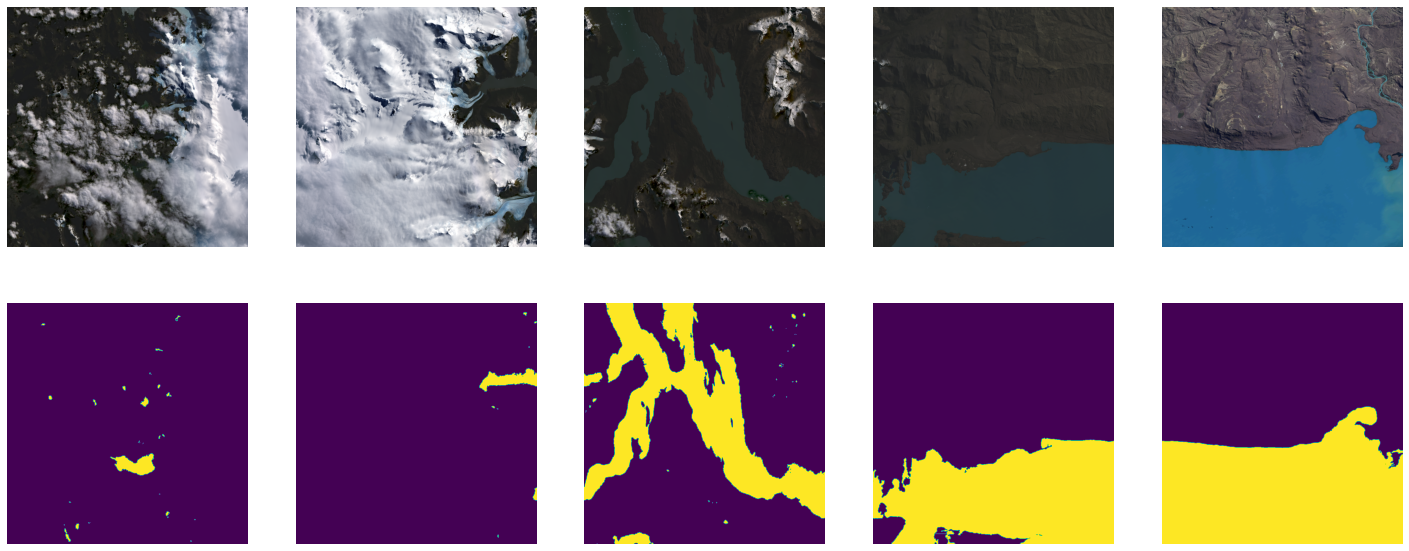

In [7]:
plt.figure(figsize=(25, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples_train[i+10].permute(1,2,0))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(labels_train[i+10].permute(1,2,0))
    plt.axis("off")

In [5]:
samples_train.shape

torch.Size([5, 3, 1024, 1024])

# Train

In [6]:
def train(loader, model, optimizer, loss_fn):
    print('train started')
    n_total_steps = len(loader)
    for epoch in range(NUM_EPOCHS):
        for i, (images, labels) in enumerate(loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # forward
            print(f'Epoch {epoch}, image {i}')
            outputs = padding(model(images), images)
            loss = loss_fn(outputs, labels)
            
            # backwards

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 1 == 0:
                print(f'epoch {epoch+1} / {NUM_EPOCHS}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')


In [7]:
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
for i in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn)


train started
Epoch 0, image 0


ValueError: Target size (torch.Size([5, 1, 1024, 1024])) must be the same as input size (torch.Size([5, 1, 1016, 1016]))

In [ ]:

check_accuracy(val_loader, model)